<a href="https://colab.research.google.com/github/andrewyyip/Capstone_Project_2/blob/master/Capstone_2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Create Training DataFrame

In [0]:
#read in image filepaths and labels
df_train = pd.read_csv('/content/gdrive/My Drive/Capstone Project 2/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Capstone Project 2/test.csv')

In [0]:
#convert target labels to str for keras model
df_train.label = df_train.label.astype(str)
df_test.label = df_test.label.astype(str)

In [0]:
#Shuffle dataframes
np.random.seed(7)
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [7]:
df_train.head()

,file_path,condition,label
325,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
680,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
4033,/content/gdrive/My Drive/Capstone Project 2/ch...,normal,0
2451,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
145,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1


In [0]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers
from keras import Sequential

In [0]:
#create data generators
datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.3)
test_datagen = ImageDataGenerator(rescale = 1/255)

In [0]:
#Define our image size
image_size = (200, 300)

Create data generators to read the data in batches

In [11]:
train_generator = datagen.flow_from_dataframe(dataframe = df_train, 
                                              x_col = 'file_path', 
                                              y_col = 'label', 
                                              directory = None,
                                              subset = 'training',
                                              target_size = image_size,
                                              batchsize = 32, 
                                              shuffle = True,
                                              color_mode = 'grayscale',
                                              class_mode = 'binary')

val_generator = datagen.flow_from_dataframe(dataframe = df_train,
                                            x_col = 'file_path',
                                            y_col = 'label',
                                            directory = None,
                                            subset = 'validation',
                                            target_size = image_size,
                                            batchsize = 32,
                                            shuffle = True,
                                            color_mode = 'grayscale',
                                            class_mode = 'binary')

test_generator = test_datagen.flow_from_dataframe(dataframe = df_test,
                                                  x_col = 'file_path',
                                                  y_col = 'label',
                                                  directory = None,
                                                  target_size = image_size,
                                                  batchsize = 32,
                                                  shuffle = False,
                                                  color_mode = 'grayscale',
                                                  class_mode = 'binary')
                                             

Found 3652 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Let's define our custom metrics.  Recall, Precision, and F1 Score.

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Let's try a simple model

In [0]:
np.random.seed(12)
model = Sequential()
model.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 298, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 149, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 147, 32)       9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 35, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 35, 64)       

In [0]:
model.compile(optimizer = 'sgd',
              loss = 'binary_crossentropy',
              metrics = ['accuracy', f1_m, recall_m, precision_m])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = step_size_train,
                              validation_data = val_generator,
                              validation_steps = step_size_val,
                              epochs = 10)



Epoch 1/10
114/114 [==============================] - 1234s 11s/step - loss: 0.1850 - acc: 0.9238 - f1_m: 0.9471 - recall_m: 0.9568 - precision_m: 0.9459 - val_loss: 0.1170 - val_acc: 0.9518 - val_f1_m: 0.9667 - val_recall_m: 0.9706 - val_precision_m: 0.9639
Epoch 2/10
114/114 [==============================] - 54s 478ms/step - loss: 0.0713 - acc: 0.9745 - f1_m: 0.9828 - recall_m: 0.9831 - precision_m: 0.9835 - val_loss: 0.0971 - val_acc: 0.9589 - val_f1_m: 0.9719 - val_recall_m: 0.9772 - val_precision_m: 0.9675
Epoch 3/10
114/114 [==============================] - 54s 474ms/step - loss: 0.0775 - acc: 0.9732 - f1_m: 0.9811 - recall_m: 0.9819 - precision_m: 0.9827 - val_loss: 0.0862 - val_acc: 0.9641 - val_f1_m: 0.9764 - val_recall_m: 0.9841 - val_precision_m: 0.9698
Epoch 4/10
114/114 [==============================] - 53s 465ms/step - loss: 0.0392 - acc: 0.9868 - f1_m: 0.9907 - recall_m: 0.9904 - precision_m: 0.9916 - val_loss: 0.0895 - val_acc: 0.9693 - val_f1_m: 0.9792 - val_recal

In [0]:
import matplotlib.pyplot as plt
def model_plots(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.legend(['acc', 'val_acc'])
  plt.title('Accuracy')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.title('Loss')
  plt.show()

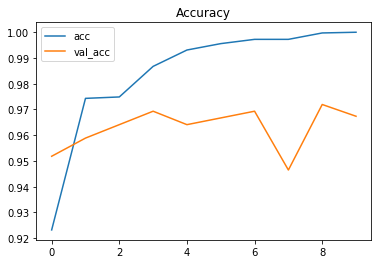

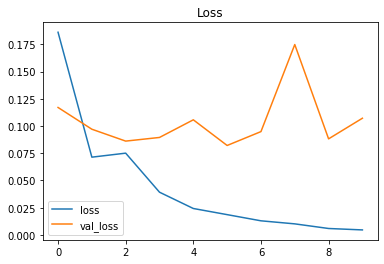

In [0]:
model_plots(history)

#Test results from 1st model

In [0]:
test_generator.reset()
step_size_test = test_generator.n // test_generator.batch_size
model_loss, model_acc, model_f1, model_recall, model_precision = model.evaluate_generator(generator = test_generator, steps = step_size_test)
print('Loss:', '%.2f'%model_loss, 'Acc:', '%.2f'%model_acc, 'F1 Score:', '%.2f'%model_f1, 'Recall:', '%.2f'%model_recall, 'Precision:', '%.2f'%model_precision)

Loss: 1.65 Acc: 0.74 F1 Score: 0.83 Recall: 1.00 Precision: 0.71


Compared to our training and validation metrics, we can see that we most likely have an overfitting issue.  Let's try a more complex model to see what we get.

#Let's try a more complex learning architecture.

In [0]:
np.random.seed(12)
model2 = Sequential()
model2.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(32, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(64, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model2.add(MaxPooling2D((2,2)))
model2.add(Conv2D(128, (3,3), strides = (1,1), activation = 'relu', input_shape = (image_size[0], image_size[1],1)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2)))
model2.add(Flatten())
model2.add(Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.1)))
model2.add(Dense(512, activation = 'relu'))
model2.add(Dropout(0.4))
model2.add(Dense(1, activation = 'sigmoid'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 198, 298, 32)      320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 149, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 97, 147, 32)       9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 73, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 35, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 33, 64)       

In [0]:
model2.compile(optimizer = 'sgd',
              loss = 'binary_crossentropy',
              metrics = ['accuracy', f1_m, recall_m, precision_m])

In [0]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size
history2 = model2.fit_generator(generator = train_generator,
                              steps_per_epoch = step_size_train,
                              validation_data = val_generator,
                              validation_steps = step_size_val,
                              epochs = 10)

Epoch 1/10
114/114 [==============================] - 52s 458ms/step - loss: 38.8493 - acc: 0.8780 - f1_m: 0.9212 - recall_m: 0.9588 - precision_m: 0.8939 - val_loss: 30.5525 - val_acc: 0.9219 - val_f1_m: 0.9461 - val_recall_m: 0.9270 - val_precision_m: 0.9684
Epoch 2/10
114/114 [==============================] - 54s 470ms/step - loss: 24.5558 - acc: 0.9534 - f1_m: 0.9680 - recall_m: 0.9705 - precision_m: 0.9669 - val_loss: 19.5677 - val_acc: 0.8649 - val_f1_m: 0.8994 - val_recall_m: 0.8230 - val_precision_m: 0.9978
Epoch 3/10
114/114 [==============================] - 54s 475ms/step - loss: 15.6058 - acc: 0.9534 - f1_m: 0.9676 - recall_m: 0.9695 - precision_m: 0.9682 - val_loss: 12.5418 - val_acc: 0.8655 - val_f1_m: 0.8997 - val_recall_m: 0.8242 - val_precision_m: 0.9955
Epoch 4/10
114/114 [==============================] - 52s 459ms/step - loss: 9.9228 - acc: 0.9657 - f1_m: 0.9764 - recall_m: 0.9773 - precision_m: 0.9769 - val_loss: 7.8873 - val_acc: 0.9465 - val_f1_m: 0.9646 - val_r

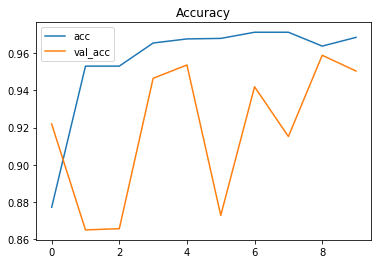

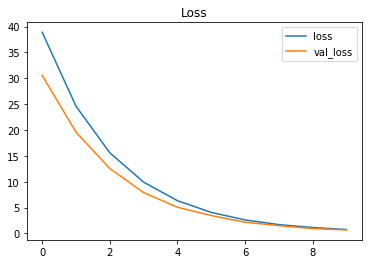

In [0]:
model_plots(history2)

#Test results from 2nd model

In [0]:
test_generator.reset()
step_size_test = test_generator.n // test_generator.batch_size
model2_loss, model2_acc, model2_f1, model2_recall, model2_precision = model2.evaluate_generator(generator = test_generator)
print('Loss:', '%.2f'%model2_loss, 'Acc:', '%.2f'%model2_acc, 'F1 Score:', '%.2f'%model2_f1, 'Recall:', '%.2f'%model2_recall, 'Precision:', '%.2f'%model2_precision)

Loss: 1.68 Acc: 0.69 F1 Score: 0.80 Recall: 1.00 Precision: 0.67


In [0]:
#save models that performed well
#model2.save('/content/gdrive/My Drive/Capstone Project 2/model-1.h5)

This does not look much better.  Our model may have become too complex, which does not help us correct our overfitting problems.  We can continue to modify our model until we get some more desirable results.  We save these models in an h5 file so that we can have them for future reference.


# Load saved model


In [17]:
from keras.models import load_model
#load saved model from folder
loaded_model = load_model('/content/gdrive/My Drive/Capstone Project 2/model-1.h5', custom_objects = {'f1_m':f1_m, 'recall_m':recall_m, 'precision_m':precision_m})
loaded_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 198, 298, 32)      320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 99, 149, 32)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 97, 147, 32)       9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 48, 73, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 46, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 23, 35, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 21, 33, 64)      

#Retrieve our training, validation, and testing metrics from our saved model

In [0]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size

#retrieve training metrics for saved model
train_generator.reset()
train_loss, train_acc, train_f1, train_recall, train_precision = loaded_model.evaluate_generator(generator = train_generator, steps=step_size_train)

#retrieve validation metrics for saved model
val_generator.reset()
val_loss, val_acc, val_f1, val_recall, val_precision = loaded_model.evaluate_generator(generator = val_generator, steps = step_size_val)

#retrieve test metrics for saved model
test_generator.reset()
test_loss, test_acc, test_f1, test_recall, test_precision = loaded_model.evaluate_generator(generator = test_generator)


#Model Results

In [16]:
print('TRAINING')
print('Loss:', "%.2f" % train_loss, 'Acc:', "%.2f" % train_acc, 'F1 Score:', "%.2f" % train_f1, 'Recall:', "%.2f" % train_recall, 'Precision:', "%.2f" % train_precision)
print('')
print('VALIDATION')
print('Loss:', "%.2f" % val_loss, 'Acc:', "%.2f" % val_acc, 'F1 Score:', "%.2f" % val_f1, 'Recall:', "%.2f" % val_recall, 'Precision:', "%.2f" % val_precision)
print('')
print('TEST')
print('Loss:', "%.2f" % test_loss, 'Acc:', "%.2f" % test_acc, 'F1 Score:', "%.2f" % test_f1, 'Recall:', "%.2f" % test_recall, 'Precision:', "%.2f" % test_precision)


TRAINING
Loss: 0.25 Acc: 0.92 F1 Score: 0.94 Recall: 0.89 Precision: 1.00

VALIDATION
Loss: 0.26 Acc: 0.92 F1 Score: 0.94 Recall: 0.90 Precision: 0.99

TEST
Loss: 0.37 Acc: 0.87 F1 Score: 0.89 Recall: 0.92 Precision: 0.87


We can see that the difference between the validation and test scores is not as extreme, suggesting that this model is not overfitting as much as the previous ones and is doing a much better job of generalizing to new data.  The accuracy and F1 scores are also higher.

In this model we have maintained a reasonably high recall score of 0.92.  It should be noted that when dealing with healthcare predictions, it may be prudent to keep a high recall to limit the number of false negatives since missing a diagnosis could potentially have much higher costs than incorrectly diagnosing a case as positive.  Any changes or improvements made to the model should take this in to consideration and try to keep the recall of the model as high as possible.

#Precision Recall Curve 
Since we have a slight imbalance, we should look at a precision recall curve and AUC score to get an idea of how our model performs.

In [0]:
predict_proba = loaded_model.predict_generator(generator = test_generator)
pred = np.multiply((predict_proba > 0.5), 1)
df_results = df_test.copy()
df_results['pred'] = pred

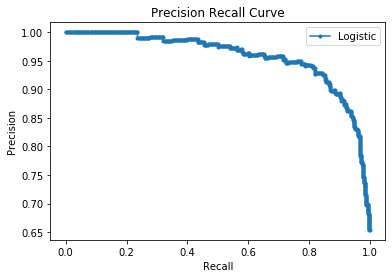

AUC Score: 0.957


In [75]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thresholds = precision_recall_curve(df_test.label.astype(int), predict_proba)

#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Recall Curve')
plt.show()

print('AUC Score: %.3f'% auc(recall, precision))

#Confusion Matrix

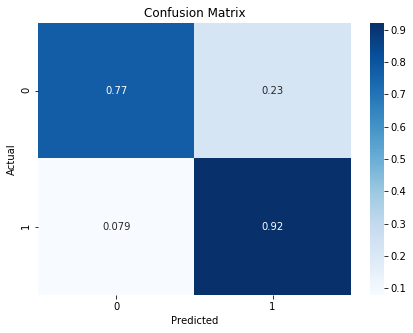

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#create confusion matrix
cm = confusion_matrix(df_results.label.astype(int), df_results.pred)
# Normalise
cm_normal = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#plot confusion matrix
plt.figure(figsize = (7,5))
sns.heatmap(cm_normal, cmap = 'Blues', annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()